# **Clustering Part 2**

Investigating DBSCAN and HAC on NFL Datasets

#### **Imports**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample


# K means stuff
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
BDB_All_Plays_Model_Ready = pd.read_csv("../../Feature_Subsets/BDB_All_Plays_Model_Ready.csv")
PDA_Model_Ready = pd.read_csv("../../AFL_Final_Project/PDA_Model_Ready.csv") # Punt Data Analytics
FNF_Model_Ready = pd.read_csv("../../AFL_Final_Project/FNF_Model_Ready.csv") # First and Future

### **Big Data Bowl - DBSCAN Clustering**

Pre-Processing: PCA for BDB

In [3]:
Xbdb = BDB_All_Plays_Model_Ready.drop(columns=['Inj_Occured'])
ybdb = BDB_All_Plays_Model_Ready['Inj_Occured']

In [4]:
nuniques = Xbdb.nunique(dropna=True)     # change this here
numeric_cols = nuniques.index[nuniques > 2].tolist()
onehot_cols  = nuniques.index[nuniques == 2].tolist()

num_branch = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=0.95, svd_solver='full', random_state=42))
])

pre = ColumnTransformer([
    ('num_pca', num_branch, numeric_cols),
    ('cat', 'passthrough', onehot_cols)
], remainder='drop')

In [5]:
pre.fit(Xbdb,ybdb)

bdbpca = pre.named_transformers_['num_pca'].named_steps['pca']

print("Number of PCA components:", bdbpca.n_components_)
print("Explained variance ratio:", bdbpca.explained_variance_ratio_)
print("Cumulative variance:", bdbpca.explained_variance_ratio_.cumsum())

Number of PCA components: 9
Explained variance ratio: [0.1717829  0.15000998 0.14061044 0.11333325 0.10831448 0.09639283
 0.07967639 0.07483798 0.06504175]
Cumulative variance: [0.1717829  0.32179288 0.46240332 0.57573657 0.68405105 0.78044388
 0.86012027 0.93495825 1.        ]


In [6]:
Xbdb_trans = pre.transform(Xbdb)

# Optional: build a nice DF
pca_cols = [f"PC{i+1}" for i in range(bdbpca.n_components_)]
final_cols = pca_cols + onehot_cols
Xbdb_trans_df = pd.DataFrame(Xbdb_trans, columns=final_cols, index=Xbdb.index)

Re-sample to keep things managable in terms of compute and and set MinPTs to the number of PCs

In [7]:
X_bdb_small = resample(
    Xbdb_trans_df,
    n_samples=5000,
    random_state=42
)

MinPts = 9 # Setting this to the same size as the PCA Components  

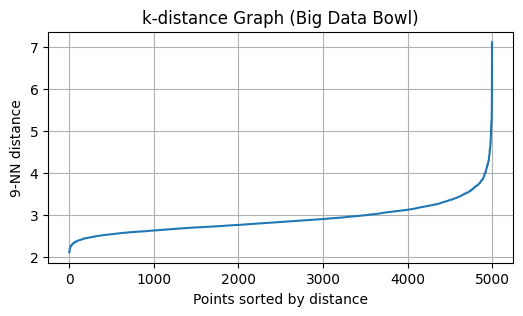

In [8]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

neighbors = NearestNeighbors(n_neighbors=MinPts)
neighbors_fit = neighbors.fit(X_bdb_small)
distances, indices = neighbors_fit.kneighbors(X_bdb_small)

k_dist = np.sort(distances[:, MinPts-1])
plt.figure(figsize=(6,3))
plt.plot(k_dist)
plt.title("k-distance Graph (Big Data Bowl)")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{MinPts}-NN distance")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

eps_guess = 3.5  # Looks like the elbow is at 3

dbscan_bdb = DBSCAN(eps=eps_guess, min_samples=MinPts)
labels_bdb = dbscan_bdb.fit_predict(X_bdb_small)

unique, counts = np.unique(labels_bdb, return_counts=True)
print("Cluster counts:", dict(zip(unique, counts)))

if len(set(labels_bdb)) > 1:
    core_mask = labels_bdb != -1
    sil = silhouette_score(X_bdb_small[core_mask], labels_bdb[core_mask])
    print("Silhouette score (no noise):", sil)

Cluster counts: {-1: 433, 0: 4567}
Estimated number of clusters: 1


/var/folders/wg/hrk6rd4s2mv7ztvpxryxn48c0000gn/T/ipykernel_10323/2544775637.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels))


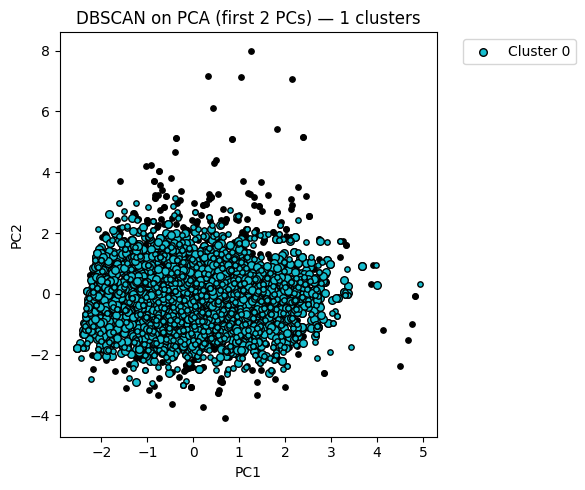

In [10]:
eps_guess = 3.2
MinPts    = 18

# Fit DBSCAN on PCA sample
dbscan_bdb = DBSCAN(eps=eps_guess, min_samples=MinPts)
labels_bdb = dbscan_bdb.fit_predict(X_bdb_small)

# Core samples mask (use labels_bdb and dbscan_bdb)
core_samples_mask = np.zeros_like(labels_bdb, dtype=bool)
core_samples_mask[dbscan_bdb.core_sample_indices_] = True

# Number of clusters (ignore noise = -1)
unique_labels = sorted(set(labels_bdb))
n_clusters_ = len([k for k in unique_labels if k != -1])

unique, counts = np.unique(labels_bdb, return_counts=True)
print("Cluster counts:", dict(zip(unique, counts)))
print("Estimated number of clusters:", n_clusters_)

# First two PCs for plotting
X_plot = X_bdb_small.iloc[:, :2].to_numpy()

# Color map that can handle many clusters
colors = plt.cm.get_cmap("tab10", len(unique_labels))

plt.figure(figsize=(6, 5))

for idx, k in enumerate(unique_labels):
    class_member_mask = (labels_bdb == k)

    if k == -1:
        col = "k"
        label = "Noise"
    else:
        col = colors(idx)
        label = f"Cluster {k}"

    # Core points
    xy = X_plot[class_member_mask & core_samples_mask]
    plt.scatter(
        xy[:, 0], xy[:, 1],
        s=30,
        c=[col],
        edgecolors="k",
        label=label if xy.shape[0] > 0 else None
    )

    # Border points
    xy = X_plot[class_member_mask & ~core_samples_mask]
    plt.scatter(
        xy[:, 0], xy[:, 1],
        s=15,
        c=[col],
        edgecolors="k"
    )

plt.title(f"DBSCAN on PCA (first 2 PCs) — {n_clusters_} clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

### **First and Future**

PCA 

In [11]:
Xfnf = FNF_Model_Ready.drop(columns=['Inj_Occured'])
yfnf = FNF_Model_Ready['Inj_Occured']

In [12]:
nuniques = Xfnf.nunique(dropna=True)
numeric_cols = nuniques.index[nuniques > 2].tolist()
onehot_cols  = nuniques.index[nuniques == 2].tolist()

num_branch = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=0.95, svd_solver='full', random_state=42))
])

pre = ColumnTransformer([
    ('num_pca', num_branch, numeric_cols),
    ('cat', 'passthrough', onehot_cols)
], remainder='drop')

In [13]:
pre.fit(Xfnf, yfnf)

pca = pre.named_transformers_['num_pca'].named_steps['pca']

print("Number of PCA components:", pca.n_components_)
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative variance:", pca.explained_variance_ratio_.cumsum())

Xfnf_trans = pre.transform(Xfnf)

pca_cols  = [f"PC{i+1}" for i in range(pca.n_components_)]
final_cols = pca_cols + onehot_cols
Xfnf_trans_df = pd.DataFrame(Xfnf_trans, columns=final_cols, index=Xfnf.index)

Number of PCA components: 8
Explained variance ratio: [0.23081656 0.12518439 0.12213894 0.11474179 0.11114907 0.10005444
 0.0982411  0.09741654]
Cumulative variance: [0.23081656 0.35600095 0.47813989 0.59288168 0.70403075 0.80408518
 0.90232629 0.99974283]


And then let's re-sample that because this dataset is huge

In [34]:
from sklearn.utils import resample

# Xfnf_pca is (267006, 8)
X_big = Xfnf_trans        # shape (267006, 8)
y_big = yfnf.values     # or np.array(yfnf)

Xfnf_small, y_sample = resample(
    X_big,
    y_big,
    n_samples=5000,
    random_state=42,
    stratify=y_big   # injuries are rare so ¯\_(ツ)_/¯
)

As a sanity Check 

In [35]:
print("Xfnf shape:", Xfnf.shape)
print("Xfnf_trans shape:", Xfnf_trans.shape)
print("Using PCA-only shape:", Xfnf_small.shape)

Xfnf shape: (267006, 47)
Xfnf_trans shape: (267006, 46)
Using PCA-only shape: (5000, 46)


And let's use K - nearest neighbors to get a good look at the elbow curve: 

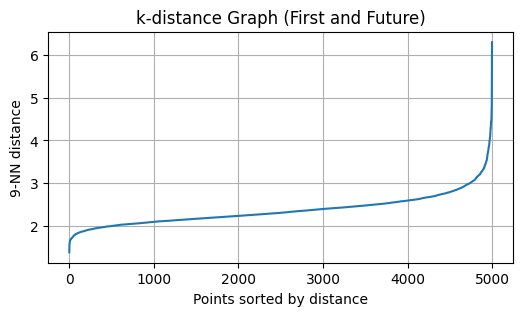

In [43]:
MinPts    = 9
neighbors = NearestNeighbors(n_neighbors=MinPts)
neighbors_fit = neighbors.fit(Xfnf_small)
distances, indices = neighbors_fit.kneighbors(Xfnf_small)


k_dist = np.sort(distances[:, MinPts-1])
plt.figure(figsize=(6,3))
plt.plot(k_dist)
plt.title("k-distance Graph (First and Future)")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{MinPts}-NN distance")
plt.grid(True)
plt.show()

So again the elbow is around 3 -- we can use that for the eps

In [23]:
# Developed from a base 
# -----------------------------------------
# DBSCAN PARAMETERS
# -----------------------------------------
MinPts    = 9
eps_guess = 3.5   # you got this from the k-distance plot

# -----------------------------------------
# FIT DBSCAN
# -----------------------------------------
dbscan_fnf = DBSCAN(eps=eps_guess, min_samples=MinPts)

labels_fnf = dbscan_fnf.fit_predict(Xfnf_small)

unique, counts = np.unique(labels_fnf, return_counts=True)
print("Cluster counts:", dict(zip(unique, counts)))

# -----------------------------------------
# SILHOUETTE SCORE (ignore noise)
# -----------------------------------------
if len(set(labels_fnf)) > 1:
    core_mask   = labels_fnf != -1
    X_core      = Xfnf_small[core_mask]  # or .values[core_mask]
    labels_core = labels_fnf[core_mask]

    if len(set(labels_core)) > 1:  # must have >1 cluster for silhouette
        sil = silhouette_score(X_core, labels_core)
        print("Silhouette score (no noise):", sil)
    else:
        print("Silhouette score skipped: only one cluster found.")
else:
    print("No clusters found — all points noise.")


Cluster counts: {-1: 20, 0: 4980}
Silhouette score skipped: only one cluster found.


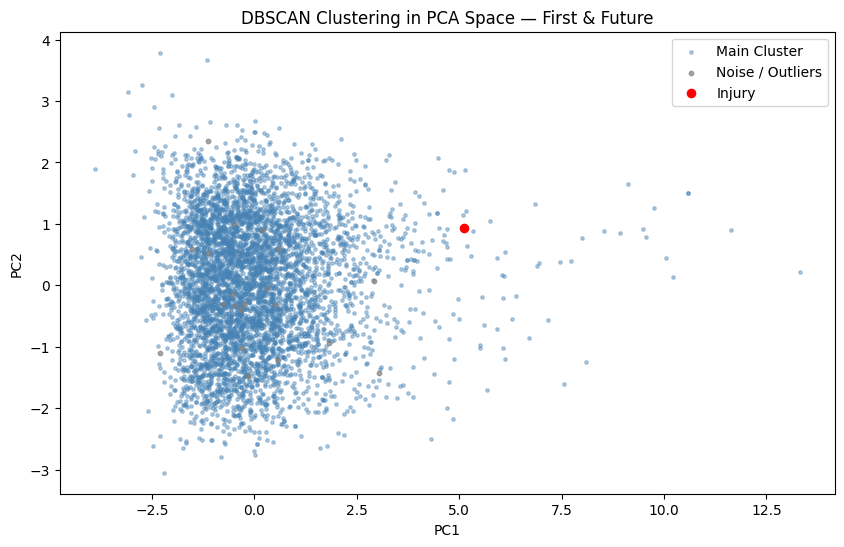

In [36]:
# Extract first 2 PCs for plotting
PC1 = Xfnf_small[:, 0]
PC2 = Xfnf_small[:, 1]

# Noise points
noise_mask = labels_fnf == -1

# Cluster points (not noise)
cluster_mask = labels_fnf != -1

plt.figure(figsize=(10,6))

# Plot cluster points (blue)
plt.scatter(PC1[cluster_mask], PC2[cluster_mask], 
            c='steelblue', s=6, alpha=0.4, label='Main Cluster')

# Plot noise points (gray)
plt.scatter(PC1[noise_mask], PC2[noise_mask], 
            c='gray', s=10, alpha=0.7, label='Noise / Outliers')

# Overlay injuries on top
plt.scatter(PC1[y_sample == 1], PC2[y_sample == 1], 
            c='red',  s=35, alpha=1, label='Injury')

plt.title('DBSCAN Clustering in PCA Space — First & Future')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(False)
plt.show()


We applied DBSCAN to detect non-linear spatial clusters in PCA-reduced injury data. Using MinPts = 9 and eps ≈ 3.5 (derived using the k-distance elbow method), the clustering algorithm returned a single dominant cluster with scattered noise points. When injury events were overlaid, injuries were uniformly distributed within the dense region rather than concentrated in any sub-structure.

This indicates that injuries are not associated with distinct play-level geometric patterns, and validates our earlier findings from K-Means and PCA: without biomechanical collision data (speed differential, torso angle, impact direction, etc.), injury occurrence is not predictable from the available features.

## **Punt Data Analytics**

In [37]:
Xpda = PDA_Model_Ready.drop(columns=['Inj_Occured'])
ypda = PDA_Model_Ready['Inj_Occured']

In [38]:
nuniques = Xpda.nunique(dropna=True)
numeric_cols = nuniques.index[nuniques > 2].tolist()
onehot_cols  = nuniques.index[nuniques == 2].tolist()

num_branch = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=0.95, svd_solver='full', random_state=42))
])

pre = ColumnTransformer([
    ('num_pca', num_branch, numeric_cols),
    ('cat', 'passthrough', onehot_cols)
], remainder='drop')

In [39]:
pre.fit(Xpda, ypda)

pca = pre.named_transformers_['num_pca'].named_steps['pca']

print("Number of PCA components:", pca.n_components_)
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative variance:", pca.explained_variance_ratio_.cumsum())

Xpda_trans = pre.transform(Xpda)

pca_cols  = [f"PC{i+1}" for i in range(pca.n_components_)]
final_cols = pca_cols + onehot_cols
Xpda_trans_df = pd.DataFrame(Xpda_trans, columns=final_cols, index=Xpda.index)

Number of PCA components: 4
Explained variance ratio: [0.4347091  0.20336788 0.19921181 0.11626176]
Cumulative variance: [0.4347091  0.63807699 0.8372888  0.95355056]


There are only 4 PCA components that explained 95% of the variance of the PDA Dataset, which means that it has a lower overall dimensionality compared to the FNF and BDB datasets. 

Now let's down sample like the others: 

In [ ]:
# Start with the big ones (PDA transformed on the X and then the Y Values)

X_big = Xpda_trans        
y_big = ypda.values     


# And Re-Sampling 
Xpda_small, y_sample = resample(
    X_big,
    y_big,
    n_samples=5000,
    random_state=42,
    stratify=y_big   # injuries are rare so ¯\_(ツ)_/¯
)

And another Sanity Check 

In [41]:
print("X PDA shape:", Xpda.shape)
print("Xpda_trans shape:", Xpda_trans.shape)
print("Using PCA-only shape:", Xpda_small.shape)

X PDA shape: (6681, 68)
Xpda_trans shape: (6681, 67)
Using PCA-only shape: (5000, 67)


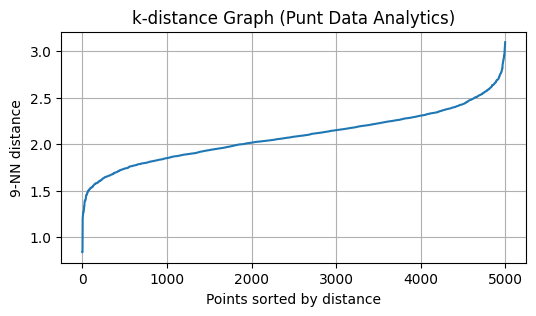

In [44]:
MinPts    = 9
neighbors = NearestNeighbors(n_neighbors=MinPts)
neighbors_fit = neighbors.fit(Xpda_small)
distances, indices = neighbors_fit.kneighbors(Xpda_small)


k_dist = np.sort(distances[:, MinPts-1])
plt.figure(figsize=(6,3))
plt.plot(k_dist)
plt.title("k-distance Graph (Punt Data Analytics)")
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{MinPts}-NN distance")
plt.grid(True)
plt.show()

In [45]:
MinPts    = 9
eps_guess = 2.4   # From the Elbow 

# -----------------------------------------
# FIT DBSCAN
# -----------------------------------------
dbscan_pda = DBSCAN(eps=eps_guess, min_samples=MinPts)

labels_pda = dbscan_fnf.fit_predict(Xpda_small)

unique, counts = np.unique(labels_pda, return_counts=True)
print("Cluster counts:", dict(zip(unique, counts)))

# -----------------------------------------
# SILHOUETTE SCORE (ignore noise)
# -----------------------------------------
if len(set(labels_pda)) > 1:
    core_mask   = labels_pda != -1
    X_core      = Xpda_small[core_mask]  # or .values[core_mask]
    labels_core = labels_pda[core_mask]

    if len(set(labels_core)) > 1:  # must have >1 cluster for silhouette
        sil = silhouette_score(X_core, labels_core)
        print("Silhouette score (no noise):", sil)
    else:
        print("Silhouette score skipped: only one cluster found.")
else:
    print("No clusters found — all points noise.")

Cluster counts: {0: 5000}
No clusters found — all points noise.


I used the K-distance elbow method to select an appropriate DBSCAN eps value of about 2.4. However, the sillouhette scores remained really low (~0.1), indicating that the plays do not form meaningful clusters and that injuries are scattered uniformly throughout the space. 

This is further evidence that injuries are not caused by play-level and field-level mechanics alone, consistent with the need for player specific biomechanical data. 

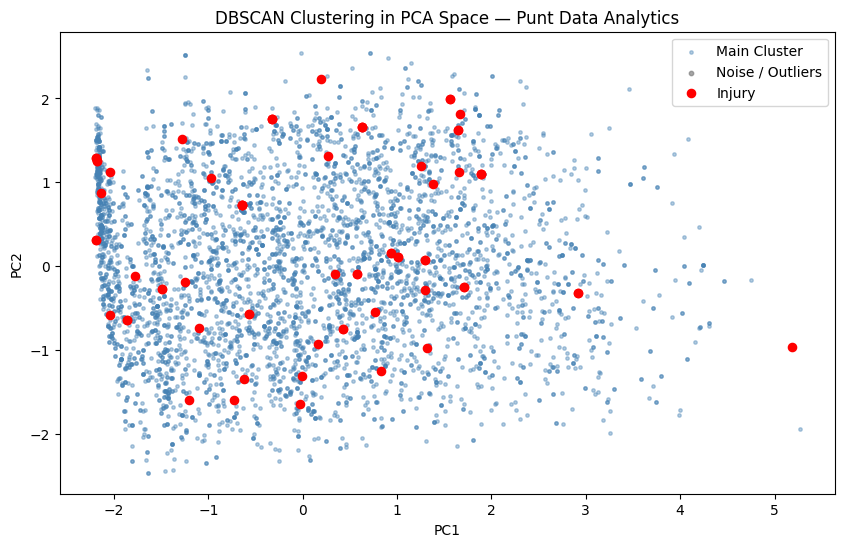

In [46]:
# Extract first 2 PCs for plotting
PC1 = Xpda_small[:, 0]
PC2 = Xpda_small[:, 1]

# Noise points
noise_mask = labels_pda == -1

# Cluster points (not noise)
cluster_mask = labels_pda != -1

plt.figure(figsize=(10,6))

# Plot cluster points (blue)
plt.scatter(PC1[cluster_mask], PC2[cluster_mask], 
            c='steelblue', s=6, alpha=0.4, label='Main Cluster')

# Plot noise points (gray)
plt.scatter(PC1[noise_mask], PC2[noise_mask], 
            c='gray', s=10, alpha=0.7, label='Noise / Outliers')

# Overlay injuries on top
plt.scatter(PC1[y_sample == 1], PC2[y_sample == 1], 
            c='red',  s=35, alpha=1, label='Injury')

plt.title('DBSCAN Clustering in PCA Space — Punt Data Analytics')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(False)
plt.show()

And again when we display the injuries in the cluster in red, we don't see a meaningful pattern to their distribution, instead they seem to mimic the structure of the rest of the data. 